Files already downloaded and verified
Files already downloaded and verified
Clean accuracy is 0.8759999871253967.
Adversarial accuracy (CNN) is 0.32199999690055847.
Adversarial accuracy (RAILS) is 0.548.


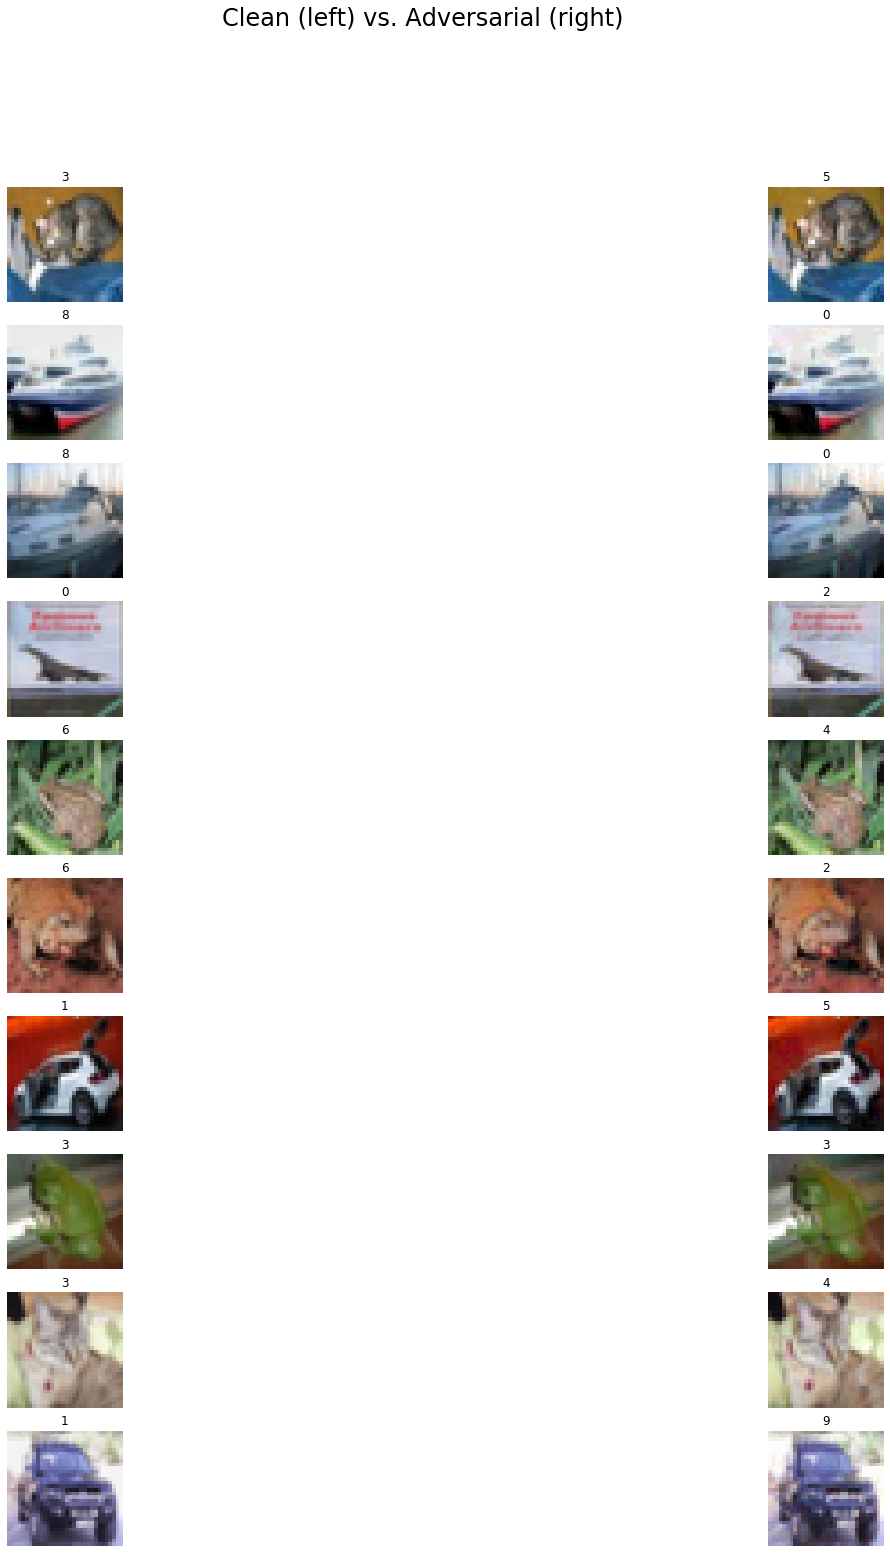

In [1]:
from aise import AISE
import torch
import torch.nn as nn
from collections import deque
import numpy as np


class RAILS:
    def __init__(self, model, configs, x_train, y_train, batch_size=512):
        self.configs = configs
        self.aise_params = self.configs.get("aise_params", None)
        self.start_layer = self.configs.get("start_layer", -1)
        self.n_class = self.configs.get("n_class", 10)
        self._model = self.reconstruct_model(model, self.start_layer)
        self.batch_size = batch_size
        with torch.no_grad():
            self.x_train = torch.cat([
                self._model.to_start(x_train[i:i + self.batch_size].to(DEVICE)).cpu()
                for i in range(0, x_train.size(0), self.batch_size)
            ], dim=0)
        self.y_train = y_train
        self.aises = [
            AISE(model=self._model, x_orig=self.x_train, y_orig=self.y_train, dataset = "cifar", **params)
            for params in self.aise_params
        ]

    def reconstruct_model(self, model, start_layer):

        class InternalModel(nn.Module):
            def __init__(self, model, start_layer=-1):
                super(InternalModel, self).__init__()
                self._model = model
                self.start_layer = start_layer
                self.feature_mappings = deque(
                    mod[1] for mod in self._model.named_children()
                    if not ("feature" in mod[0] or "classifier" in mod[0])
                )
                self.n_layers = len(self.feature_mappings)

                self.to_start = nn.Sequential()
                if hasattr(model, "feature"):
                    self.to_start.add_module(model.feature)
                for i in range(start_layer + 1):
                    self.to_start.add_module(
                        f"pre_start_layer{i}", self.feature_mappings.popleft()
                    )

                self.hidden_layers = range(self.n_layers-self.start_layer-1)

                self.truncated_forwards = [nn.Identity()]
                self.truncated_forwards.extend([
                    self._customize_mapping(hidden_layer)
                    for hidden_layer in self.hidden_layers
                ])

            def _customize_mapping(self, end_layer=None):
                feature_mappings = list(self.feature_mappings)[:end_layer + 1]

                def truncated_forward(x):
                    for map in feature_mappings:
                        x = map(x)
                    return x

                return truncated_forward

            def truncated_forward(self, hidden_layer):
                return self.truncated_forwards[hidden_layer - self.start_layer]

        return InternalModel(model, start_layer)

    def predict(self, x):
        with torch.no_grad():
            x_start = torch.cat([
                self._model.to_start(x[i:i + self.batch_size].to(DEVICE)).cpu()
                for i in range(0, x.size(0), self.batch_size)
            ], dim=0)
        pred = np.zeros((x_start.size(0), self.n_class))
        for aise in self.aises:
            pred = pred + aise(x_start)
        return pred


if __name__ == "__main__":
    from torchvision import datasets, transforms
    from torch.utils.data import DataLoader
    from models.VGG import VGG
    from pgd import PGD
    import matplotlib.pyplot as plt

    CIFAR_CONFIGS = {
        "start_layer": 1,
        "n_class": 10,
        "aise_params": [
            {"hidden_layer": 2, "sampling_temperature": 1, "max_generation": 10, "mut_range": (.005, .015)},
            {"hidden_layer": 3, "sampling_temperature": 10, "max_generation": 5, "mut_range": (.005, .015)}
        ]
    }

    ROOT = "./datasets"
    TRANSFORM = transforms.ToTensor()
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_data = datasets.CIFAR10(root=ROOT, download=True, train=True, transform=TRANSFORM)
    test_data = datasets.CIFAR10(root=ROOT, download=True, train=False, transform=TRANSFORM)
#     train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
#     test_loader = DataLoader(test_data, batch_size=1024, shuffle=False)

    x_train = (torch.FloatTensor(train_data.data[:50000])/255).permute(0,3,1,2)
    y_train = torch.LongTensor(train_data.targets[:50000])

    model = VGG()
    model.load_state_dict(torch.load(
        "./model_weights/cifar_vgg16.pt", map_location=DEVICE
    )['state_dict'])
    model.eval()

    pgd = PGD(eps=8/255,step=2/255,max_iter=10, batch_size=256)

    x_batch = (torch.FloatTensor(test_data.data[:1000])/255).permute(0,3,1,2)
    y_batch = torch.LongTensor(test_data.targets[:1000])

    x_adv = pgd.generate(model, x_batch, y_batch, device=DEVICE)

    pred_clean = model(x_batch.to(DEVICE))[-1].max(dim=1)[1].detach().cpu()
    clean_acc = (pred_clean == y_batch).float().mean().item()
    print("Clean accuracy is {}.".format(clean_acc))

    pred_adv = model(x_adv.to(DEVICE))[-1].max(dim=1)[1].detach().cpu()
    adv_acc = (pred_adv == y_batch).float().mean().item()
    print("Adversarial accuracy (CNN) is {}.".format(adv_acc))

    rails = RAILS(model, CIFAR_CONFIGS, x_train, y_train)
    pred_adv_rails = rails.predict(x_adv.to(DEVICE)).argmax(axis=1)
    adv_acc_rails = (pred_adv_rails == y_batch.numpy()).astype("float").mean().item()
    print("Adversarial accuracy (RAILS) is {}.".format(adv_acc_rails))

    IMAGE_DIR = "./images"
    fig = plt.figure(figsize=(25, 25))
    for i in range(10):
        ax = fig.add_subplot(10, 2, 2 * i + 1)
        ax.axis("off")
        ax.imshow(x_batch[i].numpy().transpose(1,2,0))
        ax.set_title(f"{pred_clean[i].item()}")
        ax = fig.add_subplot(10, 2, 2 * i + 2)
        ax.axis("off")
        ax.imshow(x_adv[i].numpy().transpose(1,2,0))
        ax.set_title(f"{pred_adv[i].item()}")
    fig.suptitle("Clean (left) vs. Adversarial (right)", fontsize=24)
    plt.savefig("./images/cifar_adv_example.png", dpi=72)